# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (2da entrega)

## Fecha de entrega

*2 de Junio de 2025*

## Integrantes

* <Florencia, Ferreyra>
* <Jerónimo, Scafati>
* <Lara, Molina>
* <Stefano, Corzini>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la función de ejemplo (`ruidoRosa_voss`)(1er entrega).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) (con las celdas ejecutas) y todos los archivos para reproducir los resultados por Slack.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [2]:
import os, sys

# 1. Calculo la ruta raíz del proyecto (un nivel arriba de notebooks/)
cwd_actual = os.getcwd()  # por ejemplo: '/home/cherry/.../TP-SyS/notebooks'
ruta_raiz = os.path.abspath(os.path.join(cwd_actual, ".."))  # '/home/cherry/.../TP-SyS'

# 2. Cambio el directorio de trabajo a esa ruta raíz
os.chdir(ruta_raiz)

# 3. Añado ruta raíz a sys.path si no estuviera
if ruta_raiz not in sys.path:
    sys.path.insert(0, ruta_raiz)

# 4. Verifico
print("CWD cambiado a →", os.getcwd())


CWD cambiado a → /home/cherry/Facur/Señales y Sistemas


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import soundfile as sf
import sounddevice as sd
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display
from scipy import signal
from src.utils.graph import graficar_dominio_temporal

## Descargar dataset
El objetivo es tener archivos para validar el software creado , para lo cual es necesario contar con la información y los datos de la medición.

### 1. Respuestas al impulso: 
**Consigna:** Descargar **al menos dos** respuestas al impulso (RI o en ingles IR, Impulse Responses) de dos recintos distintos del siguiente [link](https://www.openair.hosted.york.ac.uk/?page_id=36) y toda la información relevante de la medición, ademas de los resultados de los parametros acústicos calculados (para luego comparar). También se pueden usar los archivos dispuestos en el Drive de la asignatura. 

### 2. Sine sweep logarítmico + filtro inverso: 
**Consigna:** Descargar **al menos un** sine sweep con su respectivo filtro inverso. Una posibildiad es usar los archivos dispuestos en el GDrive de la asignatura. Para generar el filtro inverso usar la info brindada por el informe técnico en la misma carpeta de los archivos. 

## Función de carga de archivos de audio

**Consigna:** realizar una función que permita cargar archivos de audio, en lo posible \*.wav, por ejemplo los archivos anteriormente descargados. Contemplar el ingreso de más de un archivo de audio, por tipo.

Mostrar botón para seleccionar archivos

In [ ]:
files = []
def select_files(b,files=files):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    files.extend(filedialog.askopenfilenames()) # List of selected files will be set button's file attribute.
    print(files) # Print the list of files selected.

fileselect = Button(description="Seleccione el archivo")
fileselect.on_click(select_files)

display(fileselect)
files

Cargar y mostrar información de audio

In [30]:
def cargar_audio(rutas_audios):
    audios = {}
    for ruta in rutas_audios:
        data, fs = sf.read(ruta)
        audios[ruta] = (data, fs)
    for ruta, (datos, fs) in audios.items():
        print(f"Archivo: {ruta}")
        print(f"  • Frecuencia de muestreo: {fs} Hz")
        print(f"  • Número de muestras: {datos.shape[0]}")
        if datos.ndim > 1:
            print(f"  • Canales: {datos.shape[1]}")
        print("  ---------------------------")
    return audios



Llamar a la función con uno de los ejemplos anteriormente descargados y usar la función de visualización de la 1er entrega.

Archivo: /home/cherry/Facur/Señales y Sistemas/TP-SyS/audios/clifford_tower_S1R1_Bformat.wav
  • Frecuencia de muestreo: 48000 Hz
  • Número de muestras: 96000
  • Canales: 4
  ---------------------------
Archivo: /home/cherry/Facur/Señales y Sistemas/TP-SyS/audios/s1r2.wav
  • Frecuencia de muestreo: 96000 Hz
  • Número de muestras: 144000
  • Canales: 4
  ---------------------------


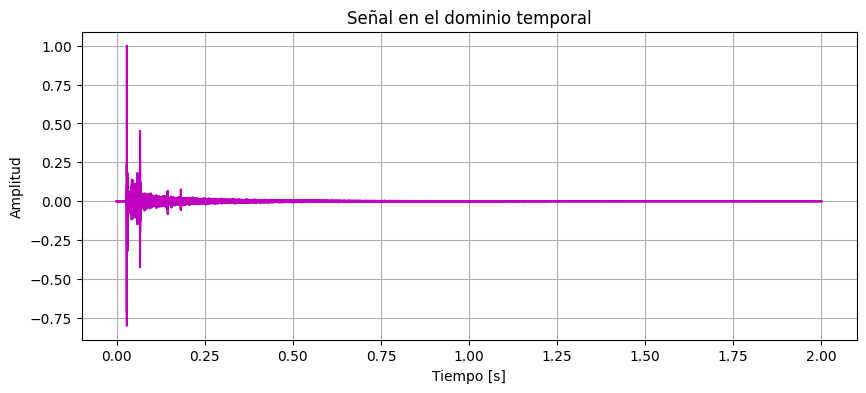

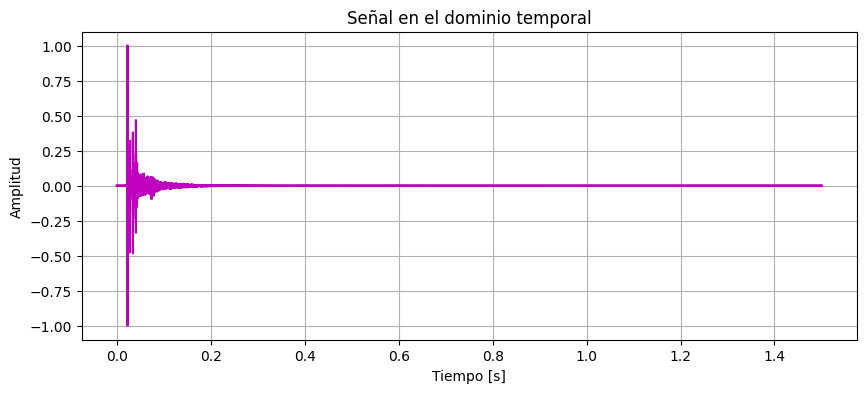

In [36]:
audios = cargar_audio(files)

for datos, fs in audios.values():
    t = np.arange(datos.shape[0]) / fs
    graficar_dominio_temporal(t,datos)


## Función de sintetización de respuesta al impulso

**Consigna:** realizar una función para sintetizar una respuesta al impulso. La misma recibira como parametro el $T60$ que se desea obtener, y deberá sintetizar una respuesta al impulso considerando las frecuencias centrales de banda de octava y tercio de octava como establece la norma IEC61260 (IEC61260,1995). La siguiente ecuación define una RI, para una frecuencia central $f_{i}$:

\begin{equation}
y_{i}=A_{i}e^{-\tau_it}\cos(2πf_{i}t)
\tag{6}
\end{equation}

donde $A_{i}$ es el coeficiente de amplitud para esa $f_{i}$(puede ser 1), y  $π_{i}$ define el decaimiento exponencial en función de $T_{60_i}$ (tiempo de reverberación) para una frecuencia $f_{i}$.

\begin{equation}
\tau_i=-\frac{ln(10^{-3})}{T_{60_i}}
\tag{7}
\end{equation}

La suma de varias frecuencias centrales $f_{i}$ se define como:
\begin{equation}
  y=\sum_{y=1}^{n}y_{i}
\tag{8}
\end{equation}

Con $n$ la cantidad de frecuencias centrales $f_{i}$ del filtro. La funcion debe recibir el tiempo de reverberacion para cada frecuencia, y devolver la respuesta al impulso correspondiente como un archivo de audio .wav. Al momento de definir la función, buscar la forma de que la misma permita varios $T60_i$ para cada frecuencia. 

> Con esta funcion se busca obtener un archivo de audio de valores de $T60_i$ conocidos que permita probar el software.

Llamar a la función con un vector que contega varios $T60$ para las cada frecuencias centrales $f_{i}$.

In [ ]:
def ri_sintetizada(frecuencias: dict,fs=44100):
    """
    Genera una respuesta al impulso sintetizada a partir de un diccionario
    de frecuencias centrales y sus respectivos (T60, Amplitud).

    Parámetros
    ----------
    frecuencias : dict
        Clave = frecuencia central (Hz).
        Valor = tupla (T60_en_segundos, Amplitud).
    fs : int
        Frecuencia de muestreo (por defecto 44100 Hz).

    Retorna
    -------
    ri_sintetizada : ndarray (1D)
        Vector con las muestras de la RI normalizada en [-1, 1].
    """
    # Definimos duracion de RI 20% mayor a T60 por banda mas grande
    t60max = max(v[0] for v in frecuencias.values())
    segundos = 1.2 * t60max
    # Crear un vector de tiempo para la RI sintetizada
    t = np.arange(0, segundos, 1/fs)  
    
    # Inicializar la RI sintetizada
    ri_sintetizada = np.zeros_like(t)
    factor = 3 * np.log(10)

    for freq, (t60, A) in frecuencias.items():
        tau_i = factor/ t60
        ri_sintetizada += A* np.exp(-tau_i * t) * np.cos(2 * np.pi * freq * t)
       
    ri_sintetizada /= np.max(np.abs(ri_sintetizada))
    ri_int16 = (ri_sintetizada * 32767).astype(np.int16)
    sf.write('./audios/ri_sintetizada.wav', ri_int16, fs)
    return ri_sintetizada

In [ ]:
# Dict con frecuencias centrales de octava con sus respectivos T60 y Amplitudes,elegidaas al azar
freq_t60 = {31.5: (2.0,1.0), 63:(3.0,1.0), 
            125:(4.8,1.0), 250:(5.7,1.0), 
            500: (3.5,1.0), 1000:(3.3,1.0), 
            2000: (4.1,1.0), 4000: (3.0,1.0), 
            8000: (5.8,1.0), 16000: (2.5,1.0)}
ri_generada = ri_sintetizada(freq_t60)

Llamar la función de visualizar el dominio temporal, de la entrega anterior.

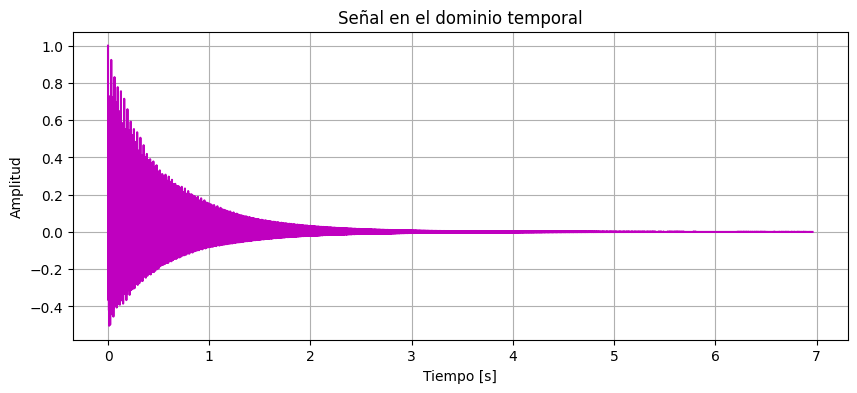

In [50]:
t = np.arange(len(ri_generada)) / 44100
graficar_dominio_temporal(t,ri_generada)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

In [ ]:
# completar

Reproducir señal resultante.

In [ ]:
sd.play(ri_generada,44100)
sd.wait()

Comentar sobre el resultado obtenido, ¿Es una buena aproximación? ¿Qué aspectos estamos dejando de lado en esta sintetización, que en un caso real estan presentes?.

*completar*

## Función obtener respuesta al impulso

**Consigna:** realizar una función que permita obtener la respuesta al impulso en formato de señal de audio .wav, a partir del sinesweep logarítmico grabado y el filtro inverso generado utilizando el siguiente método: 

Supongamos que un recinto es excitado por una señal sinesweep logarítmica $x(t)$ y captada por un micrófono $y(t)$ y buscamos la RI del recinto $h(t)$, lo anterior se expresa de la siguiente manera:

\begin{equation}
y(t)=x(t)*h(t)
\tag{9}
\end{equation}

Para un sine sweep lineal (que no es nuestro caso) el problema es sencillo, pero en nuestro caso (sine sweep logarítmico) requiere trabajar un poco respecto $x(t)$ para obtener la siguiente expresión:

\begin{equation}
h(t) = F^{-1}[H(jw)]=F^{-1}[Y(jw)K(jw)]
\tag{10}
\end{equation}

Recordar que $k(t)$ es el filtro inverso (ecu.5) y $K(jw)$ su respectiva transformada de fourier. De esta manera se obtiene la respuesta al impulso buscada.

> El desarrollo matemático de la anterior expresión se encuentra en el [Anexo I - Obtener la respuesta al impulso a partir de un sine sweep](../consigna_TP_matlab.pdf) (p.14) del instructivo para Matlab del TP.

In [ ]:
# Para la siguiente entrega reemplazar por fftconvolve de scipy 
def ri_sweep(grabacion, filtro_inverso,filename="RI_sweep.wav",fs=44100):
    """
    Devuelve la respuesta al impulso h[n] = (grabacion * filtro_inverso) en el dominio del tiempo,
    usando multiplicación de espectros (FFT).

    Parámetros
    ----------
    grabacion : array_like (1D)
        Arreglo de muestras de la señal grabada y[n] (por ejemplo, el sine‐sweep captado con micrófono).

    filtro_inverso : array_like (1D)
        Arreglo de muestras del filtro inverso k[n] que diseñaste para deconvolucionar el sine‐sweep.

    Returns
    -------
    h : ndarray (1D)
        Respuesta al impulso lineal h[n] = y[n] * k[n], de longitud len(grabacion) + len(filtro_inverso) - 1.
        Es un array real (dtype float) con la RI normalizada

    """
    # Longitud que debería tener la convolución lineal:
    N_lineal = len(grabacion) + len(filtro_inverso) - 1
    
    # Elegimos N_FFT como la siguiente potencia de 2 mayor a N_lineal (por eficiencia).
    
    N_FFT = 1 << int(np.ceil(np.log2(N_lineal)))
    
    # FFT de ambas señales completando el tamaño a N_FFT 
    FFT_grab = np.fft.fft(grabacion,      n=N_FFT)
    FFT_filt = np.fft.fft(filtro_inverso, n=N_FFT)
    
    RI = np.real(np.fft.ifft(FFT_grab * FFT_filt))
    # Tomamos solo la parte relevante de la convolución
    RI = RI[:N_lineal]  
    # Normalizar la respuesta al impulso
    RI /= np.max(np.abs(RI))
    
    # Exportamos como wav
    sf.write(filename,RI, fs)

    return RI

Llamar a la función con un sine sweep y su respectivo filtro inverso creados con la función de la primer entrega (**no** los descargados).

In [65]:
sweep, fs1 = sf.read("TP-SyS/audios/sweep.wav")
inverse, fs2 = sf.read("TP-SyS/audios/inverse_sweep.wav")

ri_sweep_con_filtro = ri_sweep(sweep,inverse)

Visualizar la señal con la función creada en la primer entrega.

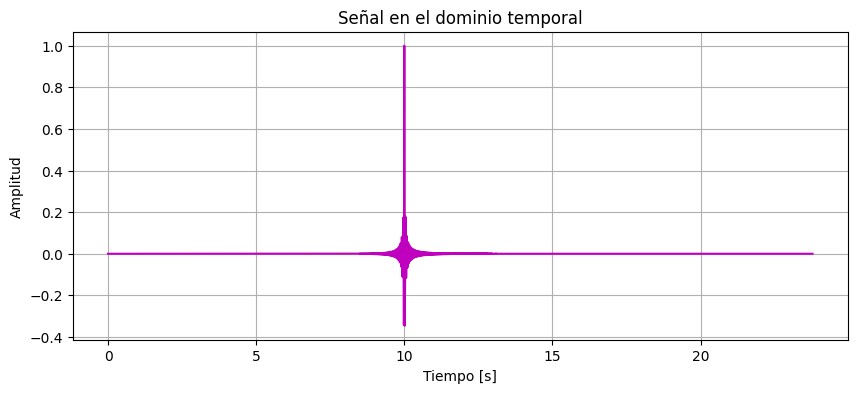

In [66]:
t = np.arange(len(ri_sweep_con_filtro)) / 44100
graficar_dominio_temporal(t,ri_sweep_con_filtro)

Reproducir señal resultante.

In [ ]:
sd.play(ri_sweep_con_filtro,44100)
sd.wait()

Comentar sobre el resultado obtenido. ¿Qué es lo que se esta escuchando? Realizar el mismo procedimiento con la señal descargada y el filtro inverso generado (para dicho sine sweep)

Se escucha un impulso en el segundo 10 del archivo, el mismo suena poco natural


In [1]:
sweep,fs = sf.read("audios/sweep_aulaInformatica.wav") 
h = sweep.shape[0]/fs
inverse = generar_inverseSweep(h)
ri_sweep_con_filtro = ri_sweep(sweep,inverse, filename="RI_aulaInformatica.wav")

NameError: name 'sf' is not defined

*completar*

Mencionar aspectos que diferencian los impulso generados en esta función, con los sintetizados.

*completar*

## Función filtros norma IEC61260

**Consigna**: Realizar una función que filtre todas las señales en octavas y tercio de octava según la norma IEC61260, con el objetivo de calcular los parámetros acústicos discriminando las frecuencias. 

Para lo cual utilizar las funciones del modulo [signals de scipy](https://docs.scipy.org/doc/scipy/reference/signal.html). Se adjunta el código capaz de calcular los coeficientes del filtro y aplicarlos a una señal. La función debe completarse con el código necesario para que este proceso se repita para cada una de las frecuencias centrales determinadas en la norma. Así mismo, el primer argumento de la función [iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) determina el grado del filtro. Evaluar el valor del mismo para que la frecuencia central de la banda coincida con las especificadas en la norma.

> Para ver una introducción breve a la implementación de filtros, usar el siguiente [documento](https://github.com/maxiyommi/signal-systems/blob/master/material_extra/Filtros/intro_filtros.ipynb).

In [ ]:
def filtros_norma_IEC61260(audiodata, fs, tipo_filtro='octava', orden_filtro=4):
    """
    Filtra una señal de audio en bandas de octava o tercio de octava según la norma IEC 61260.

    Args:
        audiodata (np.array): La señal de audio a filtrar.
        fs (int): Frecuencia de muestreo de la señal de audio (Hz).
        tipo_filtro (str): 'octava' para filtros de octava, 'tercio_octava' para tercios de octava.
        orden_filtro (int): El grado del filtro IIR.

    Returns:
        dict: Un diccionario donde las claves son las frecuencias centrales (Hz)
              y los valores son las señales de audio filtradas para esa banda.
    """

    if tipo_filtro == 'octava':
        G = 1.0 / 2.0
        # Frecuencias centrales de octava
        frecuencias_centrales = [31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
    elif tipo_filtro == 'tercio_octava':
        G = 1.0 / 6.0
        # Frecuencias centrales de tercio de octava
        frecuencias_centrales = [25, 31.5, 40, 50, 63, 80, 100, 125, 160, 200, 250,
                                 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000,
                                 2500, 3150, 4000, 5000, 6300, 8000, 10000, 12500, 16000, 20000]
    else:
        raise ValueError("El tipo_filtro debe ser 'octava' o 'tercio_octava'")

    factor = np.power(2, G)
    señales_filtradas = {}

    print(f"Filtrando con filtros de {tipo_filtro}s (Orden: {orden_filtro})...")

    for centerFrequency_Hz in frecuencias_centrales:
        lowerCutoffFrequency_Hz = centerFrequency_Hz / factor
        upperCutoffFrequency_Hz = centerFrequency_Hz * factor

        sos = signal.iirfilter(orden_filtro,
                               [lowerCutoffFrequency_Hz, upperCutoffFrequency_Hz],
                               rs=60,
                               btype='band',
                               analog=False,
                               ftype='butter', 
                               fs=fs,
                               output='sos')

        # Aplicando el filtro al audio
        filt_signal = signal.sosfilt(sos, audiodata)
        señales_filtradas[centerFrequency_Hz] = filt_signal
        print(f"  Filtrada banda de {centerFrequency_Hz} Hz (cortes: {lowerCutoffFrequency_Hz:.2f}-{upperCutoffFrequency_Hz:.2f} Hz)")

    return señales_filtradas

Llamar a la función con alguna RI generada anteriormente.

In [ ]:
audiodata, fs = sf.read("audios/ri_sintetizada.wav")
señales_octava = filtros_norma_IEC61260(audiodata, fs, tipo_filtro='octava', orden_filtro=4)

Graficar el dominio espectral del resultado en una banda, utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

In [43]:
# completar

¿El resultado es el esperado? ¿Cumple con los requerimientos de la normativa?

*completar*

## Función conversión a escala logarítmica normalizada
Para visualizar correctamente la señal es necesario realizar una función que convierta la respuesta al impulso en escala logarítmica, utilizando la siguiente expresión:

\begin{equation}
    R(t) = 20\log_{10}\frac{A(t)}{A(t)_{max}}
\tag{11}
\end{equation}

Donde $A(t)$ es la señal que deseamos transformar de escala. **Consigna:** crear una función que convierta a escala logarítmica la RI que ingresa y devuelva un array con la señal resultante.

In [ ]:
def escala_log(ri):
    """
    Convierte la respuesta al impulso (ri) a escala logarítmica normalizada

    parámetros:
    ri (numpy array): señal de respuesta al impulso

    retorna:
    - r: (numpy array) señal transformada a escala logarítmica
    """

    a_max = np.max(np.abs(ri)) 
    
    # Calcular la señal en escala logarítmica
    r = 20 * np.log10(np.abs(ri) / a_max) 
    
    return r

Llamar a la función con alguna de las señales generadas anteriormente.

In [ ]:
log_1khz = escala_log(señales_octava[1000])

Visualizar la señal con la función creada en la primer entrega.

In [ ]:
# completar

### Informe preliminar (opcional)
Realizar un informe preliminar en formato UNTREF para memorias cuatrimestrales (disponible en el Drive de la asignatura), utilizando la plataforma de dición de documentos [LaTeX](https://es.wikipedia.org/wiki/LaTeX). Respetar las siguientes consignas:
1. Mencionar los detalles en el diseño de los scripts(con ayuda de diagramas de flujo o pseudocódigo) sin agregar código propiamente dicho.
2. Describir el dataset seleccionado para probar el software.
3. El informe debe reflejar la arquitectura del software desarrollado y los avances en la producción del mismo. Los datos que se informan tienen que ser relevantes y garantizar la reproducibilidad de los mismos. No ahondar en muchos detalles teóricos y definiciones(hacer uso de referencias),hacer más bien foco en la producción del software, su evaluación y su validación.
4. El informe preliminar no debe exceder las 3 páginas. Respetar fecha de entrega.
5. Respetar los siguientes porcentajes de contenido por sección(también determinan los grados de importancia)

A modo ilustrastivo se muestra los porcentajes del contenido en los informes:

| Resumen | Introducción | Marco teórico | Desarrollo experimental | Resultados | Conclusiones |
| -- | -- | -- | -- | -- | --  |
| 5% | 10% | 10% | 25% | 30% | 20% |

> Más información en el siguiente [link](https://github.com/maxiyommi/signal-systems/tree/master/trabajo_practico#informe-t%C3%A9cnico).